In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# df_5e6 = pd.read_csv('weak_fft_10984742.csv')
# df_1e6 = pd.read_csv('weak_fft_10984754.csv')
df_250k = pd.read_csv('weak_fft_11004445.csv')
df_250k_nc = pd.read_csv('weak_fft_11018099_non_contiguous.csv')

In [3]:
df_250k.head()

,experiment_id,rank,runtime,p2m,m2m,l2l,m2l,p2p,source_tree,target_tree,...,ghost_fmm_u,displacement_map,metadata_creation,expansion_order,n_points,local_depth,global_depth,block_size,n_threads,n_samples
0,0,1,18,4,0,0,0,0,2980,2935,...,0,0,160,3,250000,4,1,128,4,500
1,0,0,244,0,0,0,82,143,2980,2935,...,0,1,168,3,250000,4,1,128,4,500
2,0,2,327,4,0,0,161,144,2980,2935,...,0,1,164,3,250000,4,1,128,4,500
3,0,3,328,4,0,0,162,143,2980,2935,...,0,0,163,3,250000,4,1,128,4,500
4,0,7,328,8,0,0,163,143,2981,2935,...,0,1,164,3,250000,4,1,128,4,500


In [4]:
n_tasks=np.array([8, 16, 32, 64, 128, 256, 512])
n_nodes=np.array([1, 1, 1, 2, 4, 8, 16])

In [5]:
def runtime_vs_npoints(df):
    npoints = []
    runtime = []
    for (id, experiment) in df.groupby('experiment_id'):
        n = experiment['n_points'].max() * experiment.shape[0]
        npoints.append(n)
        r = experiment['runtime'].mean()
        runtime.append(r)
    
    npoints = np.array(npoints)
    runtime = np.array(runtime)
    
    # unique processor counts for each experiment (same length as npoints)
    nprocs = np.array([n_tasks[i] for i in range(len(npoints))])

    # sort everything by npoints for consistent region layout
    sort_idx = np.argsort(npoints)
    npoints = npoints[sort_idx]
    runtime = runtime[sort_idx]
    nprocs = nprocs[sort_idx]

    fig, ax = plt.subplots()
    ax.plot(npoints, runtime, marker="o")
    ax.set_xscale('log')
    plt.ylim(np.min(runtime) - 10)

    # Work in log space for region boundaries
    log_x = np.log10(npoints)
    y0, y1 = ax.get_ylim()

    # Midpoints between data points (log space)
    mids = (log_x[:-1] + log_x[1:]) / 2
    # Region edges = start, mids, end
    region_edges = np.concatenate([[log_x[0]], mids, [log_x[-1]]])

    # Shade per-point region
    for i in range(len(npoints)):
        left = 10**region_edges[i]
        right = 10**region_edges[i+1]

        ax.axvspan(left, right, alpha=0.15,
                   color='orange' if i % 2 == 0 else 'lightblue')

        # Label at the data point’s x position
        ax.text(npoints[i], (y0 + y1) / 2, f"{nprocs[i]} ranks",
                ha='center', va='center', rotation=90,
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    ax.set_title(f"Weak Scaling to {npoints.max():.2e} points")
    ax.set_xlabel('Number of Points')
    ax.set_ylabel('Runtime (ms)')

    return fig, ax, nprocs, runtime



def runtime_vs_nprocesses(df):
    nranks = []
    runtime = []
    for (id, experiment) in df.groupby('experiment_id'):
        n = experiment.shape[0]
        nranks.append(n)
        r = experiment['runtime'].mean()
        runtime.append(r)
    
    nranks = np.array(nranks)
    runtime = np.array(runtime)

    # unique sorted processor counts
    nprocs = np.unique([n_nodes[i] for i in range(len(nranks))])
    boundaries = nprocs * 64

    fig, ax = plt.subplots()
    ax.plot(nranks, runtime, marker="o")
    ax.set_xscale('log')
    plt.ylim(np.min(runtime)-10)

    # Region edges (start, between boundaries, end)
    region_edges = np.concatenate([[nranks.min()], boundaries, [nranks.max()]])

    # Shade regions for each processor count
    y0, y1 = ax.get_ylim()

    # shrink factor in log space (e.g. 5% inside)
    shrink = 0.1  

    for i in range(len(nprocs)):
        left = region_edges[i]
        right = region_edges[i+1]

        # shift inward in log space
        log_left, log_right = np.log10(left), np.log10(right)
        log_pad = (log_right - log_left) * shrink
        log_left_adj = log_left - log_pad
        log_right_adj = log_right - log_pad

        left_adj = 10**log_left_adj
        right_adj = 10**log_right_adj

        ax.axvspan(left_adj, right_adj, alpha=0.15,
                   color='orange' if i % 2 == 0 else 'lightblue')

        # label in the log-midpoint
        xmid = 10**((log_left + log_right) / 2)
        ax.text(xmid, (y0 + y1) / 2, f"{nprocs[i]} nodes",
                ha='center', va='center', rotation=90,
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    ax.set_xlabel('Number of Ranks')
    ax.set_ylabel('Runtime (ms)')

    return fig, ax, nprocs, runtime




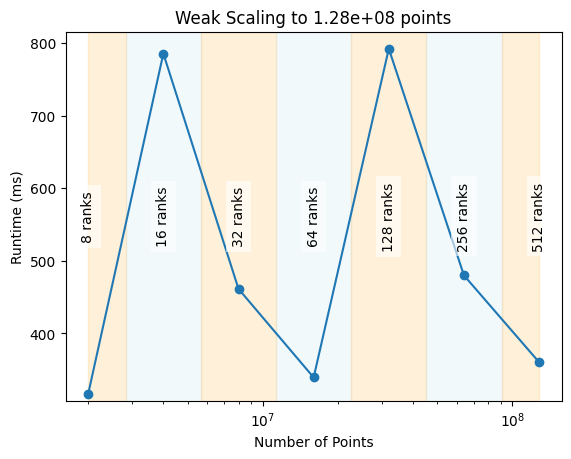

In [6]:
(fig, ax, nprocs_250k, runtime_250k) = runtime_vs_npoints(df_250k)

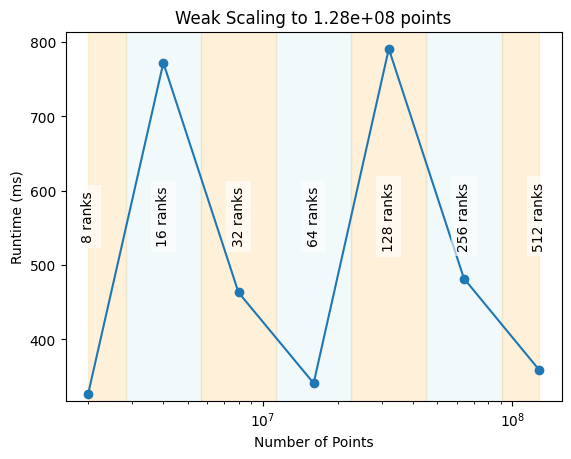

In [7]:
(fig, ax, nprocs_250k, runtime_250k) = runtime_vs_npoints(df_250k_nc)

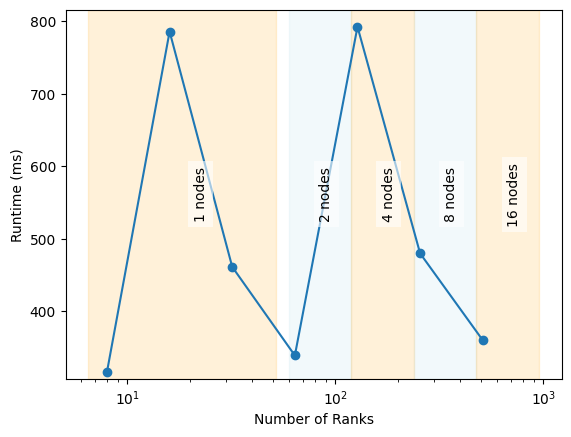

In [8]:
(fig, ax, nprocs_250k, runtime_250k) = runtime_vs_nprocesses(df_250k)

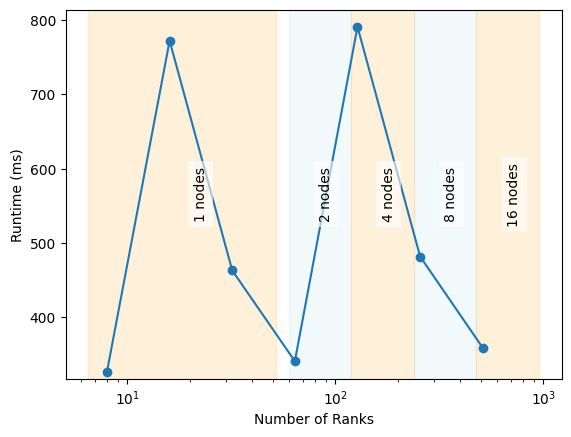

In [9]:
(fig, ax, nprocs_250k, runtime_250k) = runtime_vs_nprocesses(df_250k_nc)